In [54]:
import math
import time
import pylab
import warnings
import operator
import tldextract
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.core.display as di

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [2]:
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True
warnings.filterwarnings("ignore", category = DeprecationWarning)

### Import Legit Data and DGA Data 

In [3]:
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

t0 = time.time()
alexa_dataframe = pd.read_csv('top-1m.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']

print('Original alexa domains %d' % (alexa_dataframe.shape[0]))
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()  # remove duplicates
print('Dropna alexa domains   %d' % (alexa_dataframe.shape[0]))

alexa_dataframe['class'] = 'legit'
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Number of total Alexa domains: %d' % alexa_total)

hold_out_alexa = alexa_dataframe[int(alexa_total*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_total*.9)]
print('Number of Alexa_train domains: %d' % alexa_dataframe.shape[0])
print('Number of Alexa_test domains : %d' % hold_out_alexa.shape[0])
t1 = time.time()
print("It cost %f sec" % (t1 - t0))

Original alexa domains 1000000
Dropna alexa domains   873037
Number of total Alexa domains: 873037
Number of Alexa_train domains: 785733
Number of Alexa_test domains : 87304
It cost 11.593459 sec


In [4]:
t0 = time.time()
dga_dataframe = pd.read_csv('all_dga.txt', names=['raw_domain'], header=None, encoding='utf-8')
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

print ('Original DGA domains %d' % (dga_dataframe.shape[0]))
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print ('Dropna DGA domains   %d' % dga_total)

dga_dataframe['class'] = 'dga'

hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print('Number of DGA_train domains: %d' % dga_dataframe.shape[0])
print('Number of DGA_test domains : %d' % hold_out_dga.shape[0])
t1 = time.time()
print("It cost %f sec" % (t1 - t0))

Original DGA domains 801667
Dropna DGA domains   693090
Number of DGA_train domains: 623781
Number of DGA_test domains : 69309
It cost 2.318019 sec


In [5]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
print ('Number of all_train domains: %d' % all_domains.shape[0])

all_domains.head()

Number of all_train domains: 1409514


,domain,class
0,357le,legit
1,campfire,legit
2,baseball-mag,legit
3,egeaonline,legit
4,fs-exclue,legit


### Length and Entropy

In [6]:
t0 = time.time()
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]
all_domains['length'] = [len(x) for x in all_domains['domain']]
# all_domains = all_domains[all_domains['length'] > 6]
all_domains.columns = ['domain', 'label', 'entropy', 'length']
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))
print ("All domains:")
all_domains.head()

It cost 14.040275 sec
All domains:


,domain,label,entropy,length
0,357le,legit,2.321928,5
1,campfire,legit,3.000000,8
2,baseball-mag,legit,2.855389,12
3,egeaonline,legit,2.646439,10
4,fs-exclue,legit,2.947703,9


Red   = legit
Green = dga


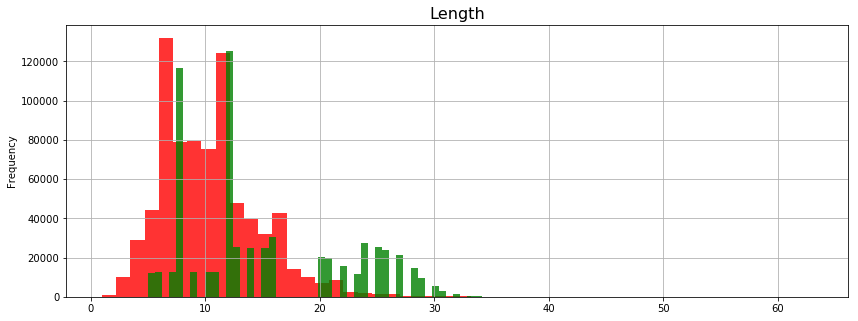

In [7]:
print ('Red   = legit')
print ('Green = dga')
all_domains[all_domains.label == "legit"].length.plot.hist(alpha = 0.8, color='r', bins = 50)
all_domains[all_domains.label == "dga"].length.plot.hist(alpha = 0.8, color='g', bins = 50)
plt.title('Length', fontsize = 16)
plt.show() 

Red = legit
Green = dga


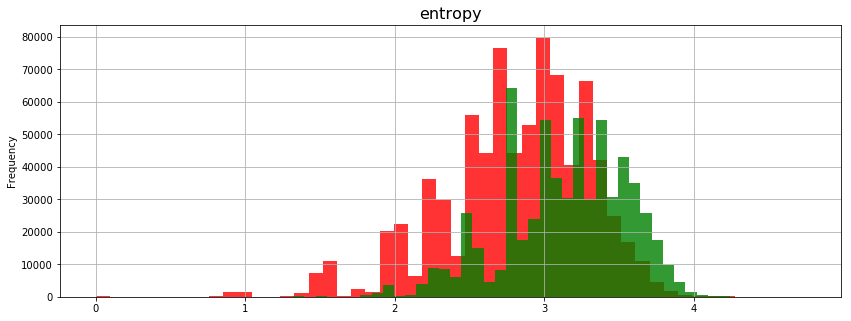

In [8]:
print ('Red = legit')
print ('Green = dga')
all_domains[all_domains.label == "legit"].entropy.plot.hist(alpha = 0.8, color='r', bins = 50)
all_domains[all_domains.label == "dga"].entropy.plot.hist(alpha = 0.8, color='g', bins = 50)
plt.title('entropy', fontsize = 16)
plt.show()

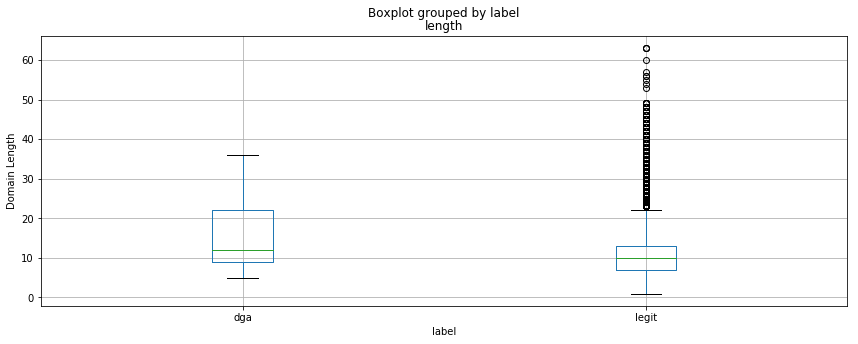

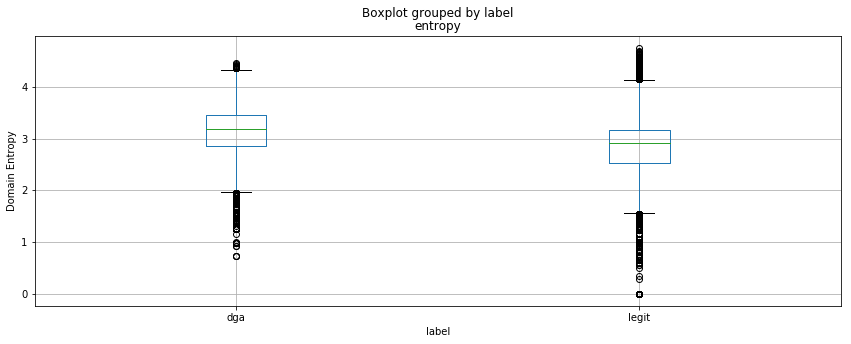

In [9]:
all_domains.boxplot('length','label')
pylab.ylabel('Domain Length')
all_domains.boxplot('entropy','label')
pylab.ylabel('Domain Entropy')
plt.show()

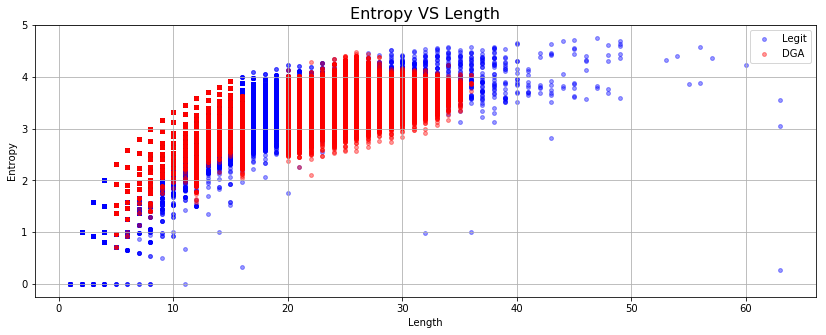

In [10]:
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]

plt.scatter(alexa['length'], alexa['entropy'], s = 15, c = 'b', label = 'Legit', alpha = 0.4)
plt.scatter(dga['length'], dga['entropy'], s = 15, c = 'r', label = 'DGA', alpha = 0.4)

plt.legend()
pylab.xlabel('Length')
pylab.ylabel('Entropy')
plt.title('Entropy VS Length', fontsize = 16)
plt.show()

### Randomforest in Length and Entropy 

In [11]:
X = all_domains.as_matrix(['length', 'entropy'])
y = np.array(all_domains['label'].tolist())
print (X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


(1409514, 2) (1409514,)


In [12]:
t0 = time.time()

rfc = RandomForestClassifier(n_estimators=200)
lgr = LogisticRegression()
rfc.fit(X_train, y_train)
#scores = sklearn.cross_validation.cross_val_score(lgr, X, y, cv=5, n_jobs=4)
#print ("Validation Score :", scores)
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

It cost 325.009468 sec


Confusion Matrix Stats
legit/legit: 76.25% (59719/78316)
legit/dga: 23.75% (18597/78316)
dga/legit: 21.05% (13187/62636)
dga/dga: 78.95% (49449/62636)


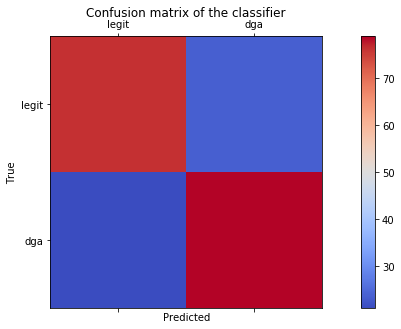

It cost 3.689753 sec
Accuracy Score : 0.774504795959


In [13]:
t0 = time.time()
y_pred = rfc.predict(X_test)
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  
    # Derp, I'm sure there's a better way
    
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('True')
    pylab.show()

plot_cm(cm, labels)
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))
print ('Accuracy Score :', accuracy_score(y_test, y_pred))

### N-Grams_CountVectorizer (all_domains, word_dataframe)

## all_domains

In [14]:
N = (3, 5)
to = time.time()
alexa_vc = CountVectorizer(analyzer='char', ngram_range=N, min_df=1e-4, max_df=1.0)

#counts_matrix = alexa_vc.fit_transform(all_domains['domain'])
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), 
                        key=operator.itemgetter(1), reverse=True)
print ('Alexa NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

Alexa NGrams: 27584
ing 4.42107719002
ine 4.32101815526
ion 4.28028236657
ent 4.2659963705
ter 4.26557246174
lin 4.26090576765
and 4.18802804134
the 4.18737969324
por 4.17043774505
ers 4.1576380641
It cost 30.287713 sec


## word_dataframe

In [15]:
word_dataframe = pd.read_csv('words.txt', names=['word'], header=None, 
                             dtype={'word': np.str}, encoding='utf-8')
#print word_dataframe.head()

### Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()

t0 = time.time()
dict_vc = CountVectorizer(analyzer = 'char',ngram_range = N,min_df = 1e-5,max_df = 1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print ('Word NGrams: %d' % len(_sorted_ngrams))

for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)
    
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

Word NGrams: 103894
ing 4.05762807296
ers 3.67182056018
ies 3.58467038446
ion 3.5166675591
ter 3.51613857672
ate 3.50826030551
ess 3.49220145139
ati 3.48784512011
est 3.44793286559
nes 3.44420098886
It cost 2.265666 sec


In [16]:
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print ('%s Alexa match : %d, Dict match : %d' % (domain, alexa_match, dict_match))

print ('Examples:')
ngram_count('argumentiru')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

Examples:
argumentiru Alexa match : 44, Dict match : 39
facebook Alexa match : 43, Dict match : 21
1cb8a5f36f Alexa match : 0, Dict match : 0
pterodactylfarts Alexa match : 54, Dict match : 41
ptes9dro-dwacty2lfa5rrts Alexa match : 30, Dict match : 19
beyonce Alexa match : 24, Dict match : 12
bey666on4ce Alexa match : 4, Dict match : 1


In [17]:
t0 = time.time()
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))
print ("All Domain")
all_domains.sort_values(by=['diff'], ascending=True).head(5)

It cost 78.582825 sec
All Domain


,domain,label,entropy,length,alexa_grams,word_grams,diff
612025,unfaithfulness,legit,3.235926,14,46.428190,60.767590,-14.339400
988837,repeatedlyrepeateddenounces,dga,3.319521,27,107.159724,121.389243,-14.229519
51019,salubriousness,legit,3.093069,14,51.440849,65.495657,-14.054808
526455,exorcized,legit,2.947703,9,16.115842,27.857604,-11.741761
337886,insidiousness,legit,2.565448,13,52.766442,64.289319,-11.522877


### new feature plot

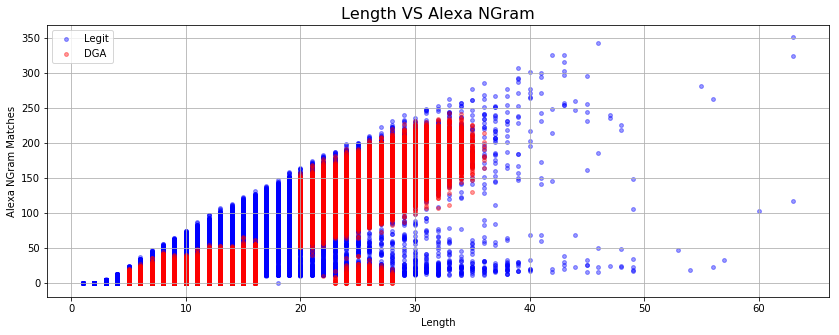

In [18]:
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]

plt.scatter(legit['length'], legit['alexa_grams'], s = 15, c = 'b', label='Legit', alpha = 0.4)
plt.scatter(dga['length'], dga['alexa_grams'], s = 15, c='r', label='DGA', alpha = 0.4)

plt.legend()
pylab.xlabel('Length')
pylab.ylabel('Alexa NGram Matches')
plt.title('Length VS Alexa NGram', fontsize = 16)
plt.show()

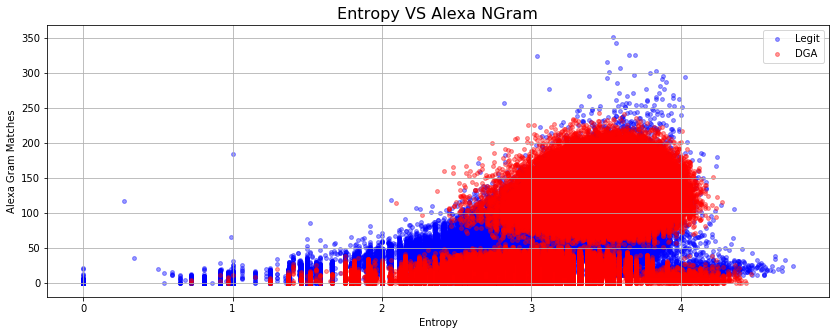

In [19]:
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=15, c='b', label='Legit', alpha=0.4)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=15, c='r', label='DGA', alpha=0.4)

plt.legend()
pylab.xlabel('Entropy')
pylab.ylabel('Alexa Gram Matches')
plt.title('Entropy VS Alexa NGram', fontsize = 16)
plt.show()

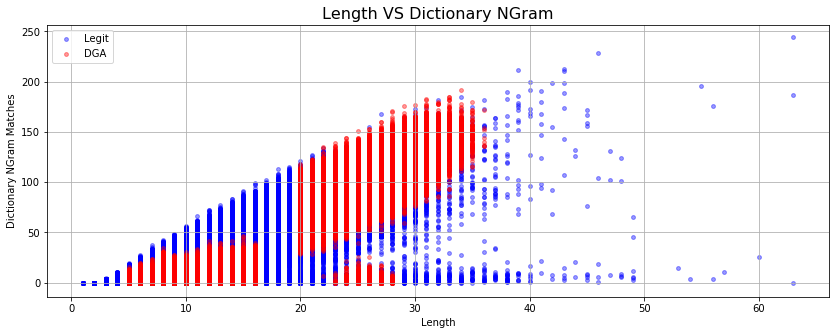

In [20]:
plt.scatter(legit['length'], legit['word_grams'],  s=15, c='b', label='Legit', alpha=.4)
plt.scatter(dga['length'], dga['word_grams'], s=15, c='r', label='DGA', alpha=.4)
plt.legend()
pylab.xlabel('Length')
pylab.ylabel('Dictionary NGram Matches')
plt.title('Length VS Dictionary NGram', fontsize = 16)
plt.show()

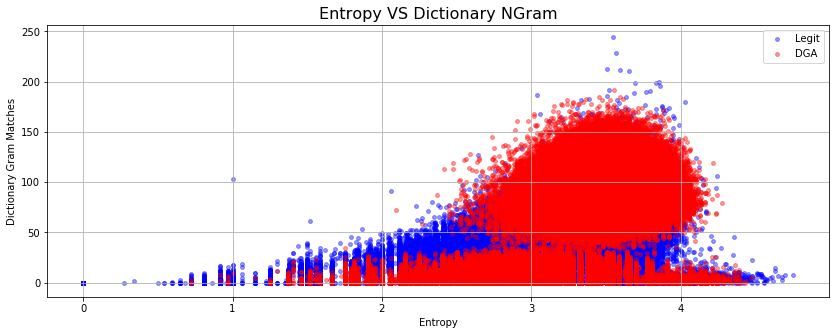

In [21]:
plt.scatter(legit['entropy'], legit['word_grams'],  s=15, c='b', label='Legit', alpha=.4)
plt.scatter(dga['entropy'], dga['word_grams'], s=15, c='r', label='DGA', alpha=.4)

plt.legend()
pylab.xlabel('Entropy')
pylab.ylabel('Dictionary Gram Matches')
plt.title('Entropy VS Dictionary NGram', fontsize = 16)
plt.show()

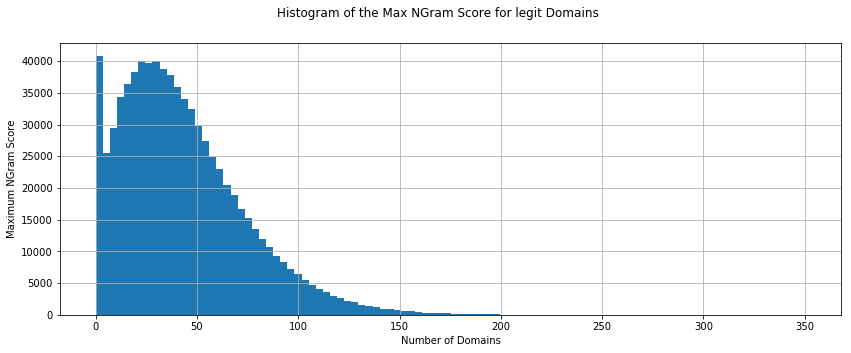

In [22]:
legit = all_domains[(all_domains['label']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=100)

ax.figure.suptitle('Histogram of the Max NGram Score for legit Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')
plt.show()

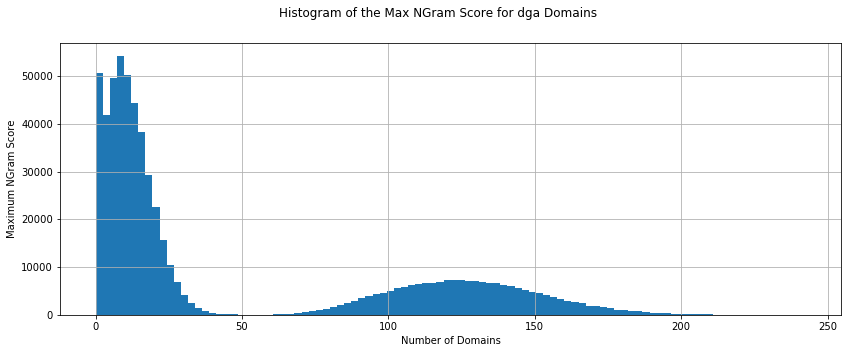

In [23]:
legit = all_domains[(all_domains['label']=='dga')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=100)
ax.figure.suptitle('Histogram of the Max NGram Score for dga Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')
plt.show()

### weird point

In [24]:
# (all_domains['label']=='legit')
weird_cond = (all_domains['word_grams'] == 0) & (all_domains['alexa_grams'] == 0)
weird = all_domains[weird_cond]
print ('Number of Weird : %d' % weird.shape[0])

Number of Weird : 38271


In [25]:
all_domains.loc[weird_cond, 'label'] = 'weird'
print (all_domains['label'].value_counts())
print ("weird data :")
all_domains[all_domains['label'] == 'weird'].head()

legit    766335
dga      604908
weird     38271
Name: label, dtype: int64
weird data :


,domain,label,entropy,length,alexa_grams,word_grams,diff
0,357le,weird,2.321928,5,0.0,0.0,0.0
7,14431,weird,1.521928,5,0.0,0.0,0.0
99,0wn0,weird,1.500000,4,0.0,0.0,0.0
128,ow,weird,1.000000,2,0.0,0.0,0.0
179,h6h66,weird,0.970951,5,0.0,0.0,0.0


In [26]:
X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(all_domains['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

t0 = time.time()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print ("accuracy_score :")
print (accuracy_score(y_test, y_pred))

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))


accuracy_score :
0.940908752301
It cost 882.294179 sec


Confusion Matrix Stats
legit/legit: 94.19% (144202/153096)
legit/weird: 0.00% (0/153096)
legit/dga: 5.81% (8894/153096)
weird/legit: 0.00% (0/7716)
weird/weird: 100.00% (7716/7716)
weird/dga: 0.00% (0/7716)
dga/legit: 6.41% (7764/121091)
dga/weird: 0.00% (0/121091)
dga/dga: 93.59% (113327/121091)


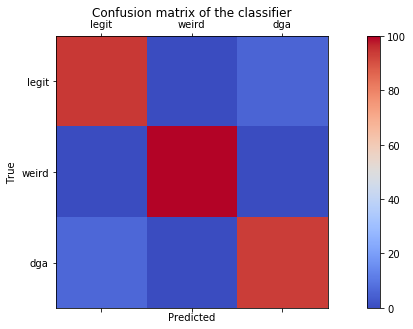

In [27]:
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)


### Evaluation: train by removing weird row

In [28]:
not_weird = all_domains[all_domains['label'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(not_weird['label'].tolist())

t0 = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rfc.fit(X_train, y_train)

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

y_pred = rfc.predict(X_test)
print ("accuracy_score")
print (accuracy_score(y_test, y_pred))


It cost 837.928570 sec
accuracy_score
0.940896776287


Confusion Matrix Stats
legit/legit: 94.37% (144861/153504)
legit/dga: 5.63% (8643/153504)
dga/legit: 6.27% (7566/120745)
dga/dga: 93.73% (113179/120745)


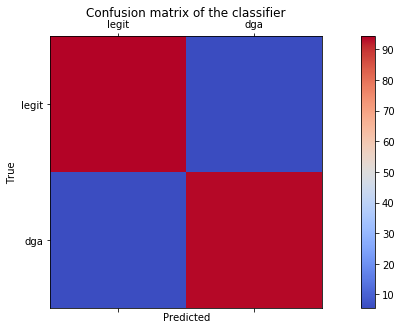

In [29]:
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)
plt.show()


### Testing

In [30]:
rfc.fit(X, y)

hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]
hold_out_domains['alexa_grams']= alexa_counts * alexa_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T
hold_out_domains.head()


,domain,class,length,entropy,alexa_grams,word_grams
0,tcyonline,legit,9,2.947703,44.210121,19.434648
1,mfhui,legit,5,2.321928,2.614897,0.845098
2,cezdistribuce,legit,13,3.238901,55.005735,36.882601
3,redcon1,legit,7,2.807355,22.030730,9.791967
4,dealground,legit,10,3.121928,50.954594,29.871382


accuracy_score
0.963125666452
Confusion Matrix Stats
legit/legit: 93.78% (81871/87304)
legit/dga: 6.22% (5433/87304)
dga/legit: 0.49% (342/69309)
dga/dga: 99.51% (68967/69309)


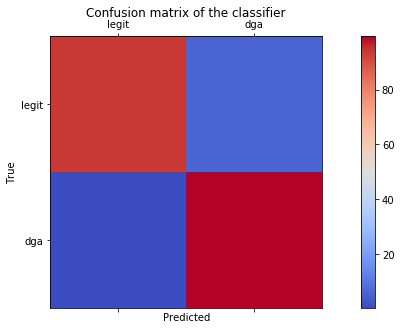

In [31]:
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
hold_y = np.array(hold_out_domains['class'].tolist())

hold_y_pred = rfc.predict(hold_X)
print ("accuracy_score")
print (accuracy_score(hold_y, hold_y_pred))

hold_out_domains['pred'] = hold_y_pred
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 
plt.show()

### FP

Number of FP: 5433


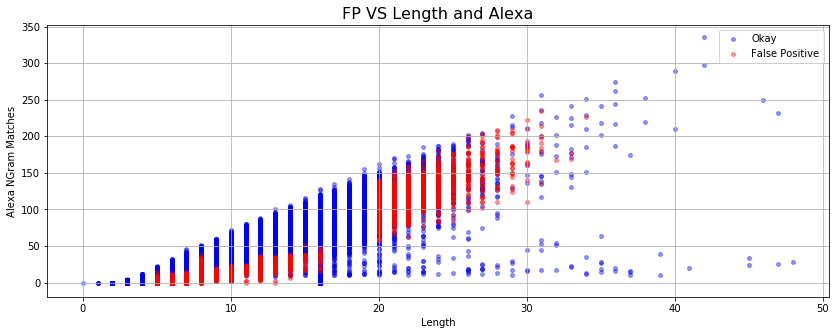

In [32]:
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
print ('Number of FP: %d' % fp.shape[0])

plt.scatter(okay['length'], okay['alexa_grams'], s = 15,  c='b', label='Okay', alpha=.4)
plt.scatter(fp['length'], fp['alexa_grams'], s = 15, c='r', label='False Positive', alpha=.4)

plt.title('FP VS Length and Alexa', fontsize = 16)
plt.legend()
pylab.xlabel('Length')
pylab.ylabel('Alexa NGram Matches')
plt.show()

Number of misclassified: 5775


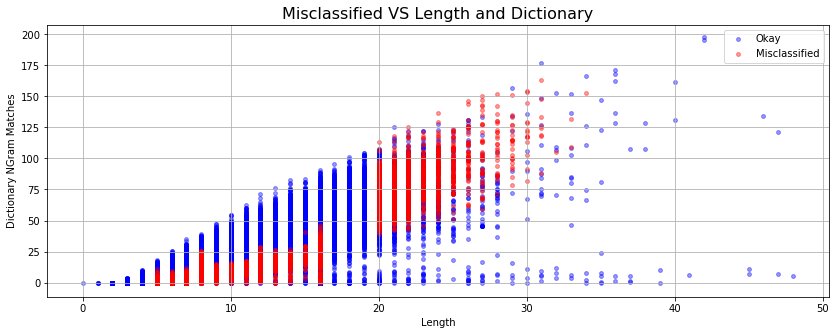

In [33]:
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
print ('Number of misclassified: %d' % misclassified.shape[0])

plt.scatter(okay['length'], okay['word_grams'], s = 15,  c='b', label='Okay', alpha=.4)
plt.scatter(misclassified['length'], misclassified['word_grams'], s = 15, c='r', label='Misclassified', alpha=.4)

plt.title('Misclassified VS Length and Dictionary', fontsize = 16)
plt.legend()
pylab.xlabel('Length')
pylab.ylabel('Dictionary NGram Matches')
plt.show()

In [35]:
def test_it(domain):
    
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot matrix multiply and transpose Woo Hoo!
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    print ('%s : %s' % (domain, rfc.predict(_X)[0]))

print ("Example :")
test_it('google')
test_it('google88')
test_it('facebook')
test_it('1cb8a5f36f')
test_it('pterodactylfarts')
test_it('ptes9dro-dwacty2lfa5rrts')
test_it('beyonce')
test_it('bey666on4ce')
test_it('supersexy')
test_it('yourmomissohotinthesummertime')
test_it('35-sdf-09jq43r')
test_it('clicksecurity')


Example :
google : legit
google88 : legit
facebook : legit
1cb8a5f36f : dga
pterodactylfarts : legit
ptes9dro-dwacty2lfa5rrts : legit
beyonce : legit
bey666on4ce : dga
supersexy : legit
yourmomissohotinthesummertime : dga
35-sdf-09jq43r : dga
clicksecurity : legit


### Try TfidfVectorizer

In [36]:
alexa_dataframe = pd.read_csv('top-1m.csv', names=['rank','uri'], 
                              header=None, encoding='utf-8')#, nrows = 1000)
print ("Original Alexa Dataframe")
print (alexa_dataframe.head())

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']

print ('Original alexa domains %d' % (alexa_dataframe.shape[0]))
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()  # remove duplicates
print ('Dropna alexa domains %d' % (alexa_dataframe.shape[0]))

alexa_dataframe['class'] = 'legit'
print ("New Alexa Dataframe")
print (alexa_dataframe.head())

alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print ('Number of total Alexa domains %d' % alexa_total)

hold_out_alexa = alexa_dataframe[int(alexa_total*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_total*.9)]
print ('Number of Alexa_train domains: %d' % alexa_dataframe.shape[0])
print ('Number of Alexa_test domains: %d' % hold_out_alexa.shape[0])


Original Alexa Dataframe
   rank           uri
0     1    google.com
1     2   youtube.com
2     3  facebook.com
3     4     baidu.com
4     5     yahoo.com
Original alexa domains 1000000
Dropna alexa domains 873037
New Alexa Dataframe
     domain  class
0    google  legit
1   youtube  legit
2  facebook  legit
3     baidu  legit
4     yahoo  legit
Number of total Alexa domains 873037
Number of Alexa_train domains: 785733
Number of Alexa_test domains: 87304


In [37]:
dga_dataframe = pd.read_csv('all_dga.txt', names=['raw_domain'], 
                            header=None, encoding='utf-8')#, nrows = 1000)
print ("Original DGA Dataframe")
print (dga_dataframe.head())

dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

print ('Original DGA domains %d' % (dga_dataframe.shape[0]))
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print ('Dropna DGA domains %d' % dga_total)

dga_dataframe['class'] = 'dga'
print ("New DGA Dataframe")
print (dga_dataframe.head())

hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print ('Number of DGA_train domains: %d' % dga_dataframe.shape[0])
print ('Number of DGA_test domains: %d' % hold_out_dga.shape[0])

Original DGA Dataframe
              raw_domain
0  ofdhiydrrttpblp.com 1
1  puciftnfkplcbhp.net 1
2  bowjjxxnhkyvygk.biz 1
3   osvwkptpwqyiqen.ru 1
4  cpmjpnwdgbxyyql.org 1
Original DGA domains 801667
Dropna DGA domains 693090
New DGA Dataframe
            domain class
0  ofdhiydrrttpblp   dga
1  puciftnfkplcbhp   dga
2  bowjjxxnhkyvygk   dga
3  osvwkptpwqyiqen   dga
4  cpmjpnwdgbxyyql   dga
Number of DGA_train domains: 623781
Number of DGA_test domains: 69309


In [38]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
print ('Number of all_train domains: %d' % all_domains.shape[0])
all_domains.head()

Number of all_train domains: 1409514


,domain,class
0,getorderly,legit
1,elitetours,legit
2,lbfl,legit
3,mrbook187,legit
4,militarbrasil,legit


In [39]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]
all_domains['length'] = [len(x) for x in all_domains['domain']]
# all_domains = all_domains[all_domains['length'] > 6]
all_domains.columns = ['domain', 'label', 'entropy', 'length']
print ("All domains:")
all_domains.head()

All domains:


,domain,label,entropy,length
0,getorderly,legit,2.921928,10
1,elitetours,legit,2.921928,10
2,lbfl,legit,1.500000,4
3,mrbook187,legit,2.947703,9
4,militarbrasil,legit,2.873141,13


In [40]:
all_domains.label = all_domains.label.astype("category").cat.codes #轉換原本不是數字的column
all_domains.head()

,domain,label,entropy,length
0,getorderly,1,2.921928,10
1,elitetours,1,2.921928,10
2,lbfl,1,1.500000,4
3,mrbook187,1,2.947703,9
4,militarbrasil,1,2.873141,13


In [41]:
N = (3,5)
t0 = time.time()
vectorizer_alexa = TfidfVectorizer(min_df = 1e-4, max_df = 1.0, analyzer = "char", 
                                   ngram_range = N)#, sublinear_tf = True)

counts_matrix = vectorizer_alexa.fit_transform(all_domains['domain'])
alexa_counts_tfidf = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = vectorizer_alexa.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts_tfidf), 
                        key=operator.itemgetter(1), reverse=True)

print ('Alexa NGrams_tfidf: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)
    
t1 = time.time()
print("It cost %f sec" % (t1 - t0))

Alexa NGrams_tfidf: 37066
the 3.78255486514
ing 3.70640733166
and 3.64891945784
ent 3.63935680434
ion 3.63651596515
ine 3.58589543681
ter 3.56770466305
est 3.54379218385
ate 3.54120348913
sta 3.52828882262
It cost 72.124333 sec


In [42]:
t0 = time.time()
vectorizer_dic = TfidfVectorizer(analyzer = 'char', ngram_range = N, min_df = 1e-5, max_df = 1.0)

counts_matrix = vectorizer_dic.fit_transform(word_dataframe['word'])
dict_counts_tfidf = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = vectorizer_dic.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, dict_counts_tfidf), 
                        key=operator.itemgetter(1), reverse=True)

print ('Word NGrams_tfidf: %d' % len(_sorted_ngrams))

for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

Word NGrams_tfidf: 103894
ing 3.0637558082
ers 2.79914369966
ies 2.69585128832
ter 2.67461585015
ate 2.65726449936
est 2.61968634848
ion 2.61762926108
ess 2.60782678588
tin 2.59866583722
ati 2.59741794449
It cost 2.867136 sec


In [43]:
t0 = time.time()
all_domains['alexa_grams_tfidf']= alexa_counts_tfidf * vectorizer_alexa.transform(all_domains['domain']).T 
all_domains['word_grams_tfidf']= dict_counts_tfidf * vectorizer_dic.transform(all_domains['domain']).T 
all_domains['diff_tfidf'] = all_domains['alexa_grams_tfidf'] - all_domains['word_grams_tfidf']
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))
print ("all domain")
all_domains.sort_values(['diff_tfidf'], ascending=True).head(5)

It cost 89.722054 sec
all domain


,domain,label,entropy,length,alexa_grams_tfidf,word_grams_tfidf,diff_tfidf
1264473,owzoa,0,1.921928,5,0.0,0.927661,-0.927661
1248233,kvzsvhjtza,0,2.921928,10,0.0,0.918627,-0.918627
1185520,cczym,0,1.921928,5,0.0,0.895521,-0.895521
1265491,zymzo,0,1.921928,5,0.0,0.895521,-0.895521
1221973,zkpzoa,0,2.251629,6,0.0,0.893207,-0.893207


In [44]:
weird_cond_tfidf = (all_domains['word_grams_tfidf'] == 0) & (all_domains['alexa_grams_tfidf'] == 0)
weird = all_domains[weird_cond_tfidf]
print ('Number of Weird : %d' % weird.shape[0])

Number of Weird : 12082


In [45]:
all_domains.loc[weird_cond_tfidf, 'label'] = 'weird'
print (all_domains['label'].value_counts())
print ("weird data:")
all_domains[all_domains['label'] == 'weird'].head()

1        774244
0        623188
weird     12082
Name: label, dtype: int64
weird data:


,domain,label,entropy,length,alexa_grams_tfidf,word_grams_tfidf,diff_tfidf
71,e4tv,weird,2.000000,4,0.0,0.0,0.0
77,bmz,weird,1.584963,3,0.0,0.0,0.0
81,9998,weird,0.811278,4,0.0,0.0,0.0
189,tb-kw,weird,2.321928,5,0.0,0.0,0.0
224,jz21,weird,2.000000,4,0.0,0.0,0.0


In [46]:
not_weird = all_domains[all_domains['label'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams_tfidf', 'word_grams_tfidf'])
y = np.array(not_weird['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
t0 = time.time()

rfc.fit(X_train, y_train)

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))
y_pred = rfc.predict(X_test)
print ("accuracy_score", accuracy_score(y_test, y_pred))


It cost 989.216005 sec
accuracy_score
0.917323524887


## Testing tfidf

In [48]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [49]:
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]
hold_out_domains['alexa_grams_tfidf']= alexa_counts_tfidf * vectorizer_alexa.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams_tfidf']= dict_counts_tfidf * vectorizer_dic.transform(hold_out_domains['domain']).T

hold_out_domains.columns = ['domain', 'label', 'length', 'entropy', 'alexa_grams_tfidf', 'word_grams_tfidf']
print ("Hold out domains")
hold_out_domains.head()

Hold out domains


,domain,label,length,entropy,alexa_grams_tfidf,word_grams_tfidf
0,track2find,legit,10,3.321928,8.680578,4.756842
1,elections,legit,9,2.947703,12.300645,7.819895
2,bebidasytragos,legit,14,3.378783,9.587157,3.544042
3,frontendaudio,legit,13,3.238901,12.241503,5.734127
4,lomamatkat,legit,10,2.446439,8.416670,2.790938


In [50]:
weird_cond_tfidf = (hold_out_domains['word_grams_tfidf'] == 0) & (hold_out_domains['alexa_grams_tfidf'] == 0)
weird = hold_out_domains[weird_cond_tfidf]

hold_out_domains.loc[weird_cond_tfidf, 'label'] = 'weird'
print (hold_out_domains['label'].value_counts())
print ("weird data :")
hold_out_domains[hold_out_domains['label'] == 'weird'].head()

legit    86028
dga      69309
weird     1276
Name: label, dtype: int64
weird data :


,domain,label,length,entropy,alexa_grams_tfidf,word_grams_tfidf
39,hw4,weird,3,1.584963,0.0,0.0
152,ur8lv,weird,5,2.321928,0.0,0.0
193,xzrj,weird,4,2.000000,0.0,0.0
295,qlr,weird,3,1.584963,0.0,0.0
321,uy,weird,2,1.000000,0.0,0.0


In [51]:
not_weird = hold_out_domains[hold_out_domains['label'] != 'weird']
not_weird.label = not_weird.label.astype("category").cat.codes

hold_X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams_tfidf', 'word_grams_tfidf'])
hold_y = np.array(not_weird['label'].tolist())

/Users/Shawn/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Confusion Matrix Stats
legit/legit: 98.92% (68562/69309)
legit/dga: 1.08% (747/69309)
dga/legit: 8.06% (6930/86028)
dga/dga: 91.94% (79098/86028)


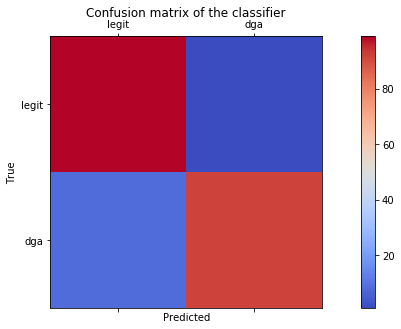

In [52]:
hold_y_pred = rfc.predict(hold_X)

not_weird['pred'] = hold_y_pred
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred)
plot_cm(cm, labels) 
plt.show()

In [58]:
not_weird.label = not_weird.label.astype("category").cat.codes
hold_X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams_tfidf', 'word_grams_tfidf'])
hold_y = np.array(not_weird['label'].tolist())

fpr, tpr, _ = roc_curve(hold_y, (rfc.predict_proba(hold_X)[:, 1]))
auc = auc(fpr, tpr)

print("Accuracy : %f" % rfc.score(hold_X, hold_y))  #checking the accuracy
print("Precision: %f" % precision_score(hold_y, hold_y_pred))
print("Recall   : %f" % recall_score(hold_y, hold_y_pred))
print("F1-Score : %f" % f1_score(hold_y, hold_y_pred))
print("AUC      : %f" % auc)

/Users/Shawn/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


TypeError: 'numpy.float64' object is not callable

# Directly

In [62]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)
all_domains.columns = ['domain', 'label']
all_domains.label = all_domains.label.astype("category").cat.codes
print ('Number of all_train domains: %d' % all_domains.shape[0])
all_domains.head()

Number of all_train domains: 1409514


,domain,label
0,getorderly,1
1,elitetours,1
2,lbfl,1
3,mrbook187,1
4,militarbrasil,1


## count

In [63]:
X = alexa_vc.fit_transform(all_domains['domain'])
y = np.array(all_domains["label"].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
t0 = time.time()

lgr = LogisticRegression()
lgr.fit(X_train, y_train)

t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

y_pred = lgr.predict(X_test)
print ("accuracy_score")
print (accuracy_score(y_test, y_pred))

It cost 710.027883 sec
accuracy_score
0.961128473269


In [64]:
### Hold out
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)
hold_out_domains.columns = ['domain', 'label']
hold_out_domains.label = hold_out_domains.label.astype("category").cat.codes
print ("Hold out domains")
hold_out_domains.head()

Hold out domains


,domain,label
0,track2find,1
1,elections,1
2,bebidasytragos,1
3,frontendaudio,1
4,lomamatkat,1


accuracy_score
0.984356343343
Confusion Matrix Stats
legit/legit: 99.59% (69027/69309)
legit/dga: 0.41% (282/69309)
dga/legit: 2.48% (2168/87304)
dga/dga: 97.52% (85136/87304)


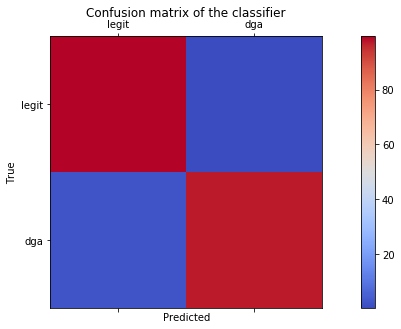

In [65]:
X_hold = alexa_vc.transform(hold_out_domains['domain'])
y_hold = np.array(hold_out_domains["label"].tolist())

hold_y_pred = lgr.predict(X_hold)
print ("accuracy_score")
print (accuracy_score(y_hold, hold_y_pred))

labels = ['legit', 'dga']
cm = confusion_matrix(y_hold, hold_y_pred)
plot_cm(cm, labels) 
plt.show()

## tfidf

In [66]:
X = vectorizer_alexa.fit_transform(all_domains['domain'])
y = np.array(all_domains["label"].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

t0 = time.time()
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
t1 = time.time()
print ("It cost %f sec" % (t1 - t0))

y_pred = lgr.predict(X_test)
print ("accuracy_score")
print (accuracy_score(y_test, y_pred))


It cost 10.979557 sec
accuracy_score
0.95438501896


accuracy_score
0.976419582027
Confusion Matrix Stats
legit/legit: 99.40% (68891/69309)
legit/dga: 0.60% (418/69309)
dga/legit: 3.75% (3275/87304)
dga/dga: 96.25% (84029/87304)


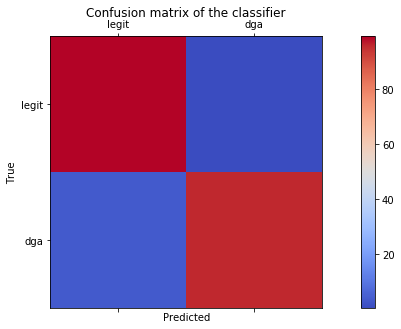

In [67]:
X_hold = vectorizer_alexa.transform(hold_out_domains['domain'])
y_hold = np.array(hold_out_domains["label"].tolist())

hold_y_pred = lgr.predict(X_hold)
print ("accuracy_score")
print (accuracy_score(y_hold, hold_y_pred))

labels = ['legit', 'dga']
cm = confusion_matrix(y_hold, hold_y_pred)
plot_cm(cm, labels) 
plt.show()
